In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import argparse
from architecture import MicrocolonyNet
from datatools import McolonyTestData
from dann import DANN
from prototype_net import ProtoTypeDANN
import matplotlib.pyplot as plt
# Input image dimensions (match this with your dataset)
max_px = 1002
min_px = 1002


/home/bhatta70/miniconda3/envs/mcolony-classification/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bhatta70/miniconda3/envs/mcolony-classification/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [30]:

# Arguments from command line
root_train ='/mnt/data/mcolony-classification/20x/train90/'
root ='/mnt/projects/bhatta70/test/brightfield/'
workers=0
batch =1
ckpt = '/mnt/projects/bhatta70/Microcolony-AutoAugment/lightning_logs/mcolony/version_0/checkpoints/mcolony-epoch=52-val_loss_epoch=0.44.ckpt'

# Set multiprocessing strategy to 'file_system' for pytorch
torch.multiprocessing.set_sharing_strategy('file_system')

# Get class names from the training dataset directory
ds_classes = sorted(os.listdir(root_train))
print("Classes: ", ds_classes)

# Get experimental group name from test dataset directory
ds_group = root.split('/')[-2]

# Initialize DataModule   
print("Loading dataset from ", root)
ds = McolonyTestData(root=root)
test_dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=workers, pin_memory=False)

model= DANN.load_from_checkpoint(ckpt)
model.cuda()    # Move model to GPU
for param in model.parameters():
    param.requires_grad = False
print('Model loaded')

itt = iter(test_dl)
batches = int(np.ceil(len(ds)/batch))

name_list = []
pred_list = []
gt_list = []

original_images = []
optimized_images = []
# Loop over data batches
for i in tqdm(range(batches)):
    d = next(itt)
    input = d[0]['image'].to('cuda')
    original_images.append(input.detach().cpu().numpy())
    fname = d[1]
    input.requires_grad = True
    # noise_data = torch.randn_like(input) * 0.1
    # noise_data.requires_grad = True

    # Perform inference
    model.eval()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD([input], lr=0.005)

    labels = torch.tensor([4]).to('cuda')
    for i in range(500):
        _, class_logits, _ = model(input, alpha=1)
        loss = criterion(class_logits, labels)
        loss.backward()
        optimizer.step()
        if i%10 == 0:
            print("Loss: ", loss.item())

        if loss.item() < 0.02:
            break
    optimized_images.append(input.detach().cpu().numpy())
    break
                




Classes:  ['Bc-20x', 'Bs-20x', 'Ec-20x', 'Li-20x', 'SE-20x', 'ST-20x']
Loading dataset from  /mnt/projects/bhatta70/test/brightfield/
Model loaded


  0%|                                                                      | 0/60 [00:00<?, ?it/s]

Loss:  13.691561698913574


  0%|                                                                      | 0/60 [00:02<?, ?it/s]

Loss:  0.053442973643541336


In [27]:
class_logits

tensor([[-6.7764, -5.1402,  0.0734,  1.1584,  1.6950,  6.1841]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

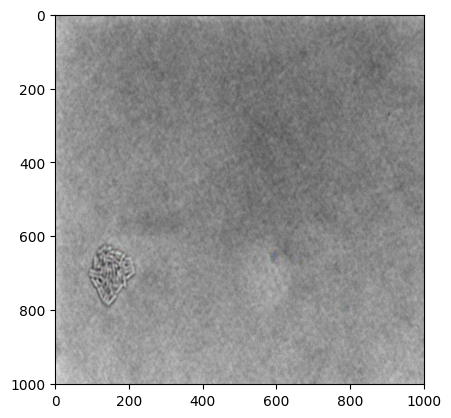

In [31]:
plt.imshow(input.cpu().detach().numpy().squeeze().transpose(1,2,0))
plt.show()
with torch.no_grad():
    _, class_logits, _  = model(input, alpha=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


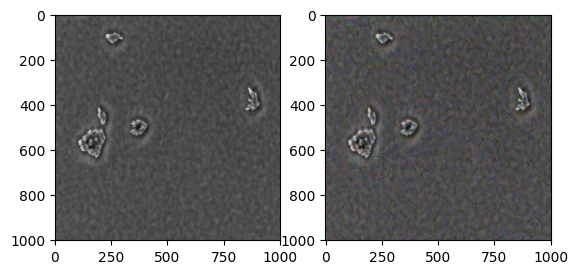

tensor([[ 7.7708, -4.3024, -6.2815, -3.4811,  3.5649,  0.1124]],
       device='cuda:0')


In [4]:

for i, (original, optimized) in enumerate(zip(original_images, optimized_images)):
    fig, ax = plt.subplots(1,2)
    orignal_reshaped = original.squeeze().transpose(1,2,0)
    optimized_reshaped = optimized.squeeze().transpose(1,2,0)
    ax[0].imshow(orignal_reshaped, cmap='gray')
    ax[1].imshow(optimized_reshaped, cmap='gray')
    plt.show()


    # predict
    model.eval()
    with torch.no_grad():
        _, logits, _ = model(torch.tensor(optimized).to('cuda'), alpha=1)
        print(logits)
        break

In [10]:
noise_data.squeeze().permute(1,2,0).detach().cpu().numpy()

array([[[ 0.00556145,  0.05518975,  0.0111307 ],
        [-0.00208457, -0.11679194,  0.10610075],
        [ 0.00586966, -0.02369566,  0.03305796],
        ...,
        [ 0.1798276 ,  0.03042062,  0.05398967],
        [ 0.07209512, -0.05320067, -0.06286501],
        [ 0.07743575,  0.09864996,  0.04086594]],

       [[-0.01327918, -0.01687429,  0.08514939],
        [ 0.12018767,  0.03376732, -0.05767754],
        [-0.03176962, -0.11740442, -0.18043986],
        ...,
        [-0.01474874,  0.01888795, -0.10647493],
        [-0.21937788, -0.01874538,  0.06121245],
        [ 0.00203709,  0.18694524, -0.12907797]],

       [[-0.01064412,  0.07477723, -0.04742786],
        [ 0.07358325,  0.00131008,  0.18365453],
        [ 0.01018284,  0.0812518 ,  0.01035886],
        ...,
        [-0.04840759,  0.13288744, -0.11294086],
        [-0.09691191, -0.22701693,  0.18947442],
        [ 0.13859268,  0.0895206 ,  0.0035746 ]],

       ...,

       [[-0.08738708, -0.05718657,  0.00175657],
        [ 0